# Introduction

## Prêt à mener la mission ?

Vous êtes consultant pour <a href="https://olist.com/">Olist</a>, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.


Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.


Vous venez de rejoindre Olist dans un contexte de recrutement intensif afin de monter leur équipe Data. En effet, ils font d’abord appel à des consultants comme vous en renfort sur les sujets les plus critiques en attendant d'internaliser les compétences. Avant de réaliser la segmentation client, on vous attribue une première mission pour aider Fernanda, Lead Data Analyst chez Olist. 


Après avoir étudié les éléments partagés par Fernanda vous vous mettez au travail.


------------------------

## Quelques jours plus tard
 

Cette urgence résolue, vous pouvez enfin passer à votre mission principale : Olist souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.


Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
 

Vous devrez fournir à l’équipe Marketing **une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


**<u>Les données</u>**

Pour cette mission, Olist vous fournit une <a href="https://course.oc-static.com/projects/olist.db">base de données</a> anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.


------------------------
 
## 3 jours plus tard
 

Après quelques premières analyses, vous vous rendez compte qu'Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l'entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission.


Vous réalisez trois autres documents afin de préparer une réponse à Olist : 

- Un notebook avec des essais des différentes approches de modélisation 
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent 
- Une présentation pour un collègue afin d’obtenir ses retours sur votre approche
 

C’est parti pour cette dernière ligne droite ! 

# Import des librairies

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Chargement de seaborn

In [2]:
sns.set()

# Lecture du dataset

In [3]:
# Read the dataset from the csv file made previously
df = pd.read_csv("data_cleaned.csv")

In [4]:
# Print the head of the dataframe
df.head()

,Unnamed: 0,customer_unique_id,customer_zip_code_prefix,order_purchase_timestamp,days_since_last_order,total_orders,total_value,mean_review_score
0,0,0000366f3b9a7992bf8c76cfdf3221e2,7787,2018-05-10 10:56:27,111,1,141.90,5.0
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,2018-05-07 11:11:27,114,1,27.19,4.0
2,2,0000f46a3911fa3c0805444483337064,88115,2017-03-10 21:05:03,536,1,86.22,3.0
3,3,0000f6ccb0745a6a4b88665a16c9f078,66812,2017-10-12 20:29:41,320,1,43.62,4.0
4,4,0004aac84e0df4da2b147fca70cf8255,18040,2017-11-14 19:45:42,287,1,196.89,5.0


# Ségmentation RFM

Afin d'appliquer la méthode RFM sur notre set de clients, nous allons calculer, pour chaque composante (récence, fréquence, montant), un score compris entre 1 et 4, en compartimentant nos données, à l'aide de la méthode des quartiles.

<a href="https://www.cartelis.com/blog/segmentation-rfm-definition-calcul/">Source des calculs effectués</a>

In [5]:
# Define a list with the features needed for the RFM segmentation
rfm_features = ["days_since_last_order", "total_orders", "total_value"]
# Make a copy of the original dataframe, with only the required features
rfm = df[rfm_features].copy()

## Score de récence

Tout d'abord, visualisons les séparations de nos compartiments :

In [6]:
# Print quantiles for the days_since_last_order feature
df["days_since_last_order"].quantile([0.25, 0.5, 0.75])

0.25    113.0
0.50    218.0
0.75    345.0
Name: days_since_last_order, dtype: float64

Les compartiments sont cohérents, calculons le score de récence

In [7]:
# Cut the dataframe into bins based on the quantiles
rfm["Score R"] = pd.qcut(x=df["days_since_last_order"], q=4, labels=[4, 3, 2, 1]).astype(int)

Visualisons notre répartition

In [8]:
# Count number of values for each bins
rfm["Score R"].value_counts()

Score R
3    23451
4    23396
1    23311
2    23200
Name: count, dtype: int64

## Score de fréquence

Tout d'abord, visualisons les séparations de nos compartiments :

In [9]:
# Print quantiles for the total_orders feature
df["total_orders"].quantile([0.25, 0.5, 0.75])

0.25    1.0
0.50    1.0
0.75    1.0
Name: total_orders, dtype: float64

Les quantiles de fréquence ne sont pas représentatifs, aussi adoptons une autre manière de compartimenter en procédant ainsi :
- un premier pour compartiment pour les clients ayant effectués 1 achat,
- un deuxième compartiment pour les clients ayant effectués 2 achats,
- un troisème compartiment pour les clients ayant effectués entre 2 et 5 achats,
- un dernier compartiment pour les clients ayant effectués plus de 5 achats.

In [10]:
# Create a pd.IntervalIndex object to categorize the number of orders
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 5), (5, 100)])
# Use the pd.cut to compartmentalize the customers
# Note : as the pd.cut returns a CategoricalDtype, we use .cat.codes to convert the categories to integer and add 1 
rfm["Score F"] = pd.cut(x=df["total_orders"], bins=bins).cat.codes + 1

Visualisons notre répartition

In [11]:
# Count number of values for each bins
rfm["Score F"].value_counts()

Score F
1    90557
2     2573
3      218
4       10
Name: count, dtype: int64

## Score de montant

Tout d'abord, visualisons les séparations de nos compartiments :

In [12]:
# Print quantiles for the total_value feature
df["total_value"].quantile([0.25, 0.5, 0.75])

0.25     61.32
0.50    106.10
0.75    180.04
Name: total_value, dtype: float64

Les compartiments sont cohérents, calculons le score de récence

In [13]:
# Cut the dataframe into bins based on the quantiles
rfm.loc[:, "Score M"] = pd.qcut(x=df["total_value"], q=4, labels=[1, 2, 3, 4]).astype(int)

Visualisons notre répartition

In [14]:
# Count number of values for each bins
rfm["Score M"].value_counts()

Score M
1    23341
2    23341
4    23339
3    23337
Name: count, dtype: int64

## Catégorisation des clients

Afin de représenter la catégorisation de nos clients, nous allons définir des segments selon les scores de récence, fréquence et montant comme suit :

| **Segment**                  | **Récence (R)** | **Fréquence (F)** | **Montant (M)** | **Description**                                         |
|------------------------------|-----------------|-------------------|----------------|------------------------------------------------------|
| **Champions**                | 4               | 2 à 4            | ≥3             | Clients très récents, actifs et avec un montant élevé. |
| **Clients fidèles**          | 4               | 2 à 4            | 2 à 3          | Clients récents, plusieurs commandes, montant modéré.  |
| **Clients potentiels**       | 3 ou 4          | 1                | ≥1             | Nouveaux clients, faible fréquence mais potentiel d'achat. |
| **Clients en déclin**        | 2               | 1 à 2            | ≥1             | Moins récents, faible fréquence mais montant modéré à élevé. |
| **Clients perdus (faible dépense)** | 1 ou 2          | 1 à 2            | ≤2             | Clients peu récents, faible fréquence et faible montant. |
| **Clients perdus (montant élevé)**  | 1 ou 2          | 1 à 2            | >2             | Clients peu récents, faible fréquence mais montant élevé. |



Appliquons ensuite notre catégorisation

In [15]:
# Initialize a new column for the clustering in the dataframe
# Make its value "Autres"
rfm["Catégorie client"] = "Autres"

# Sort our customers based on the table showed previously
# 1. Champions : Très récents, actifs, montant élevé
rfm.loc[(rfm["Score R"] == 4) & (rfm["Score F"].between(2, 4)) & (rfm["Score M"] >= 3), 
        "Catégorie client"] = "Champions"

# 2. Clients fidèles : Récents, plusieurs commandes, montant modéré
rfm.loc[(rfm["Score R"] == 4) & (rfm["Score F"].between(2, 4)) & (rfm["Score M"].between(2, 3)) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients fidèles"

# 3. Clients potentiels : Récents (R=3 ou 4), faible fréquence mais potentiel
rfm.loc[(rfm["Score R"].between(3, 4)) & (rfm["Score F"] == 1) & (rfm["Score M"] >= 1) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients potentiels"

# 4. Clients en déclin : Moins récents, faible fréquence mais montant modéré à élevé
rfm.loc[(rfm["Score R"] == 2) & (rfm["Score F"].between(1, 2)) & (rfm["Score M"] >= 1) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients en déclin"

# 5. Clients perdus (faible dépense) : Peu récents, faible fréquence et petit montant
rfm.loc[(rfm["Score R"].between(1, 2)) & (rfm["Score F"].between(1, 2)) & (rfm["Score M"] <= 2) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients perdus (faible dépense)"

# 6. Clients perdus (montant élevé) : Peu récents, faible fréquence mais montant élevé
rfm.loc[(rfm["Score R"].between(1, 2)) & (rfm["Score F"].between(1, 2)) & (rfm["Score M"] > 2) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients perdus (montant élevé)"

Affichons la répartition de nos catégories

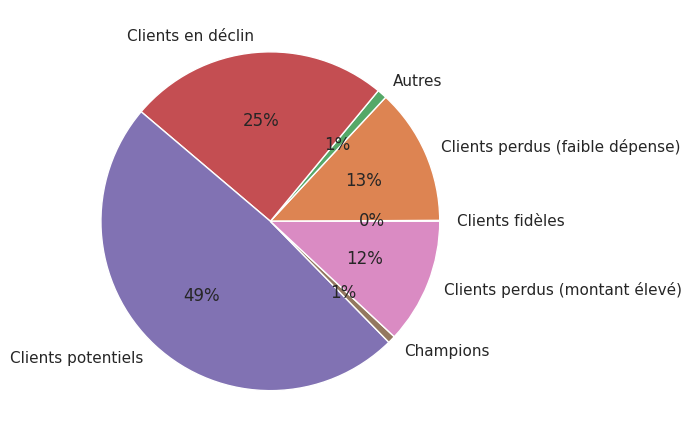

In [16]:
# Calculate the percentage of each category 
data = rfm["Catégorie client"].value_counts()*100 / rfm.shape[0]
# Mix lines in order not to have little numbers near to each other
data = data.sample(frac=1, random_state=5)
# Print a pie chart of the different catagories
plt.pie(x=data, labels=data.index, autopct='%.0f%%')
plt.show()

# K-Means avec 3 variables

## Normalisation des données

In [17]:
# Define a list with the features needed for the RFM segmentation
rfm_features = ["days_since_last_order", "total_orders", "total_value"]
# Make a copy of the original dataframe, with only the required features
rfm_3var = df[rfm_features].copy()

Nous avons pu constaté lors de l'analyse exploratoire que les variables "total_orders" et "total_value" présentent un grand nombre d'outliers.

Aussi, nous allons leur appliquer une transformation logarithmique afin de diminuer le phénomène.

Dans un second temps nous centrerons et réduirons les données, à l'aide d'un StandardScaler.

### total_orders

Avant transformation

<Axes: xlabel='total_orders', ylabel='Density'>

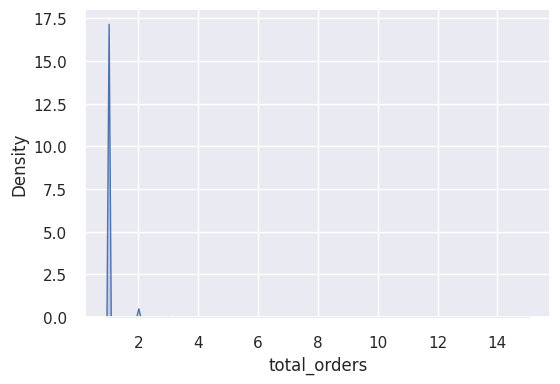

In [18]:
# Plot the distribution of the total_orders feature
plt.figure(figsize=(6,4))
sns.kdeplot(data=rfm_3var["total_orders"], fill=True)

Après transformation

<Axes: xlabel='total_orders', ylabel='Density'>

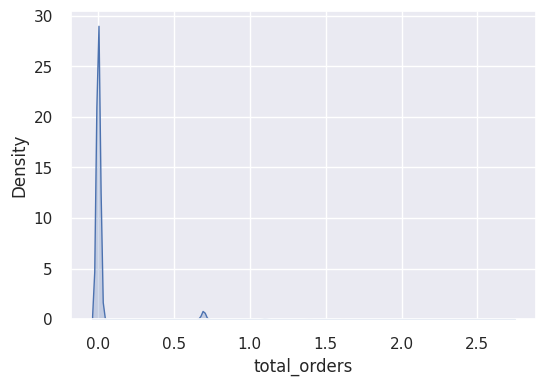

In [19]:
# Plot the distribution of the total_orders feature transformed with the log function
plt.figure(figsize=(6,4))
sns.kdeplot(data=np.log(rfm_3var["total_orders"]), fill=True)

On note moins d'outliers, nous validons donc l'application de cette transformation

In [20]:
# Replace the total_orders value by it's log value
rfm_3var["total_orders"] = np.log(rfm_3var["total_orders"])

### total_value

Avant transformation

<Axes: xlabel='total_value', ylabel='Density'>

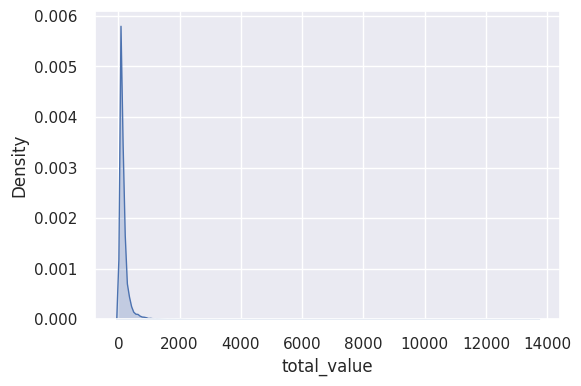

In [21]:
# Plot the distribution of the total_orders feature
plt.figure(figsize=(6,4))
sns.kdeplot(data=rfm_3var["total_value"], fill=True)

Après transformation

<Axes: xlabel='total_value', ylabel='Density'>

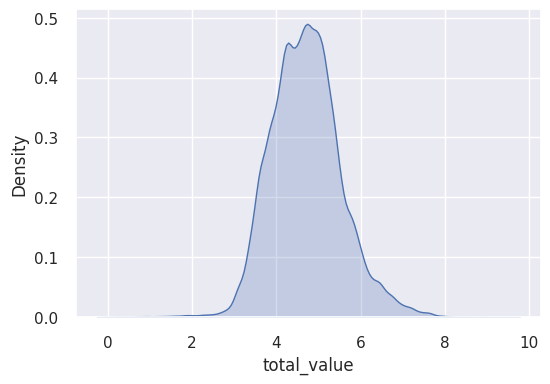

In [22]:
# Plot the distribution of the total_orders feature transformed with the log function
plt.figure(figsize=(6,4))
sns.kdeplot(data=np.log1p(rfm_3var["total_value"]), fill=True)

On note moins d'outliers, nous validons donc l'application de cette transformation

In [23]:
# Replace the total_orders value by it's log value
rfm_3var["total_value"] = np.log1p(rfm_3var["total_value"])

### Normalisation

Appliquons à présent le StandardScaler pour centrer-réduire les données

In [24]:
# Define a StandardScaler object
scaler = StandardScaler()
# Use it on our dataframe to get standardized values
rfm_3var_scaled = scaler.fit_transform(rfm_3var)

## Choix du nombre de clusters

Afin de sélectionner le bon nombre de clusters, nous allons appliquer la méthode du coude d'une part et la méthode de la silhouette d'autre part

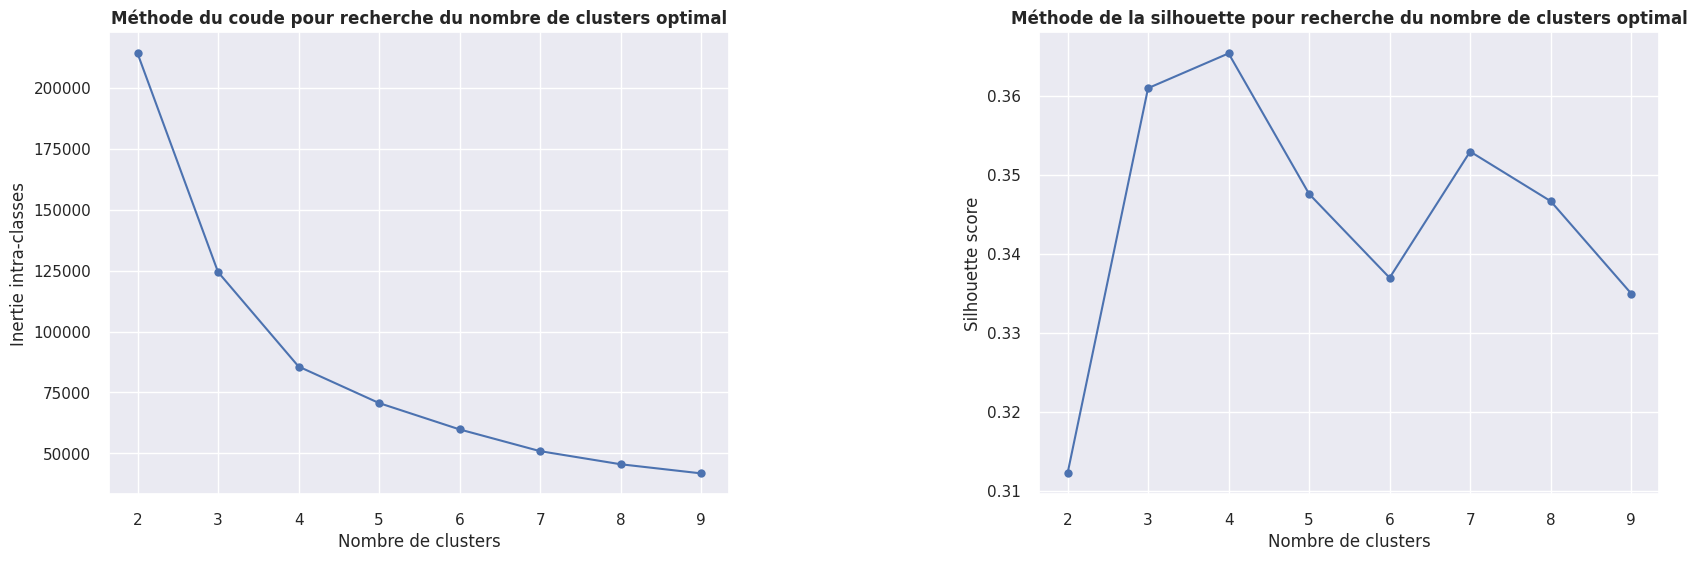

In [25]:
# Define a number of clusters, between 2 and 10
K = range(2,10)
# Define a list to store the inertias
inerties = []
# Define a list to store the silhouettes scores
silhouettes = []

for k in K:
    # Initialize the model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=8)
    # Train the model
    kmeans.fit(rfm_3var_scaled)
    # Get the computed labels
    cluster_labels = kmeans.labels_

    # Calcule inertia and silhouette scores
    inerties.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_3var_scaled, cluster_labels))

# Create a figure with 1 line and 2 columns
plt.figure(figsize = (20, 6))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)

# In the first subplot, plot the results of the elbow method
plt.subplot(grid[0,0])
plt.plot(K, inerties, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Inertie intra-classes") 
plt.title("Méthode du coude pour recherche du nombre de clusters optimal", fontweight="bold")

# In the second subplot, plot the results of the silhouette method
plt.subplot(grid[0,1])
plt.plot(K, silhouettes, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Silhouette score") 
plt.title("Méthode de la silhouette pour recherche du nombre de clusters optimal", fontweight="bold")

plt.show()

Les deux méthodes préconisent entre 3 et 4 clusters, nous essayerons les deux pour les départager

## Clustering avec 3 et 4 clusters

Dans un premier temps visualisons les clusters produits sur un  graphique en deux dimensions avec :
- en X la récence
- en Y la fréquence
- et en Z le montant

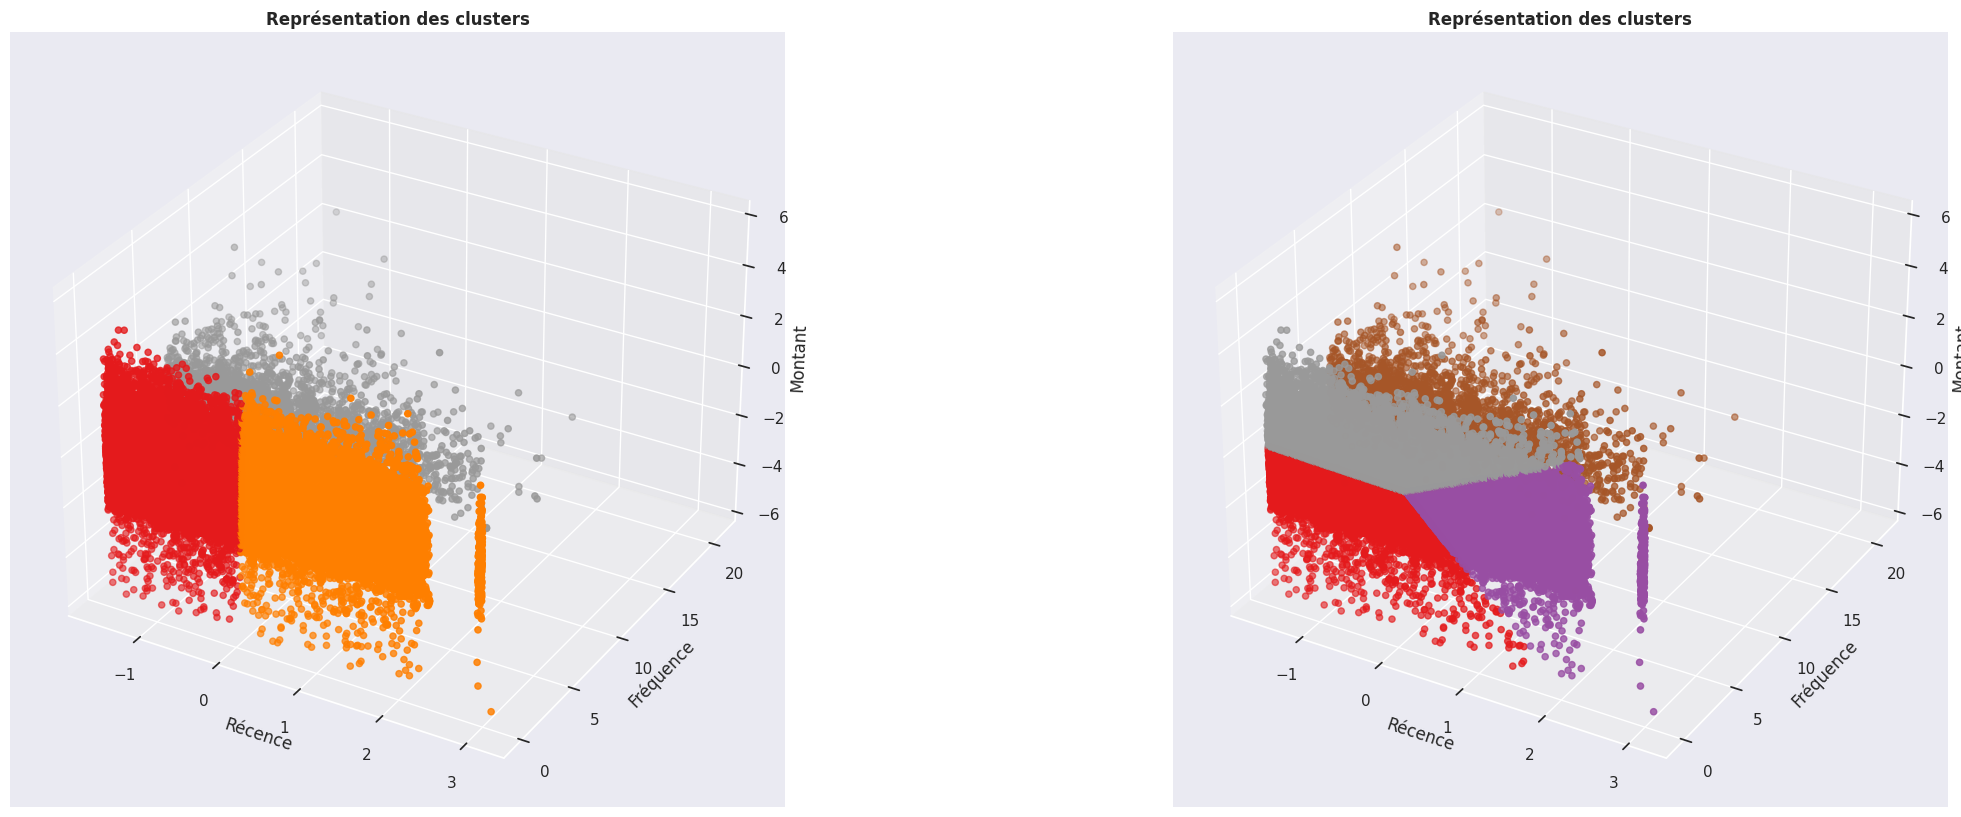

In [26]:
# Create a figure with 1 line and 2 columns
fig = plt.figure(figsize=(25,20))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)
sns.set_palette("Set1")

# Train the first model with 3 clusters
kmeans_3var_3clus = KMeans(n_clusters=3, random_state=8)
kmeans_3var_3clus.fit(rfm_3var_scaled)
# Define a 3D subplot
ax1 = fig.add_subplot(grid[0,0], projection="3d")
# Plot the values colored by labels
ax1.scatter(xs=rfm_3var_scaled[:, 0], ys=rfm_3var_scaled[:, 1], 
    zs=rfm_3var_scaled[:, 2], c=kmeans_3var_3clus.labels_, cmap="Set1")
ax1.set_xlabel("Récence")
ax1.set_ylabel("Fréquence")
ax1.set_zlabel("Montant")
plt.title("Représentation des clusters", fontweight="bold")

# Train the first model with 4 clusters
kmeans_3var_4clus = KMeans(n_clusters=4, random_state=8)
kmeans_3var_4clus.fit(rfm_3var_scaled)
# Define a 3D subplot
ax2 = fig.add_subplot(grid[0,1], projection="3d")
# Plot the values colored by labels
ax2.scatter(xs=rfm_3var_scaled[:, 0], ys=rfm_3var_scaled[:, 1], 
    zs=rfm_3var_scaled[:, 2], c=kmeans_3var_4clus.labels_, cmap="Set1")
ax2.set_xlabel("Récence")
ax2.set_ylabel("Fréquence")
ax2.set_zlabel("Montant")
plt.title("Représentation des clusters", fontweight="bold")

plt.show()

Ensuite, nous visualisons les silhouettes des deux clusterings

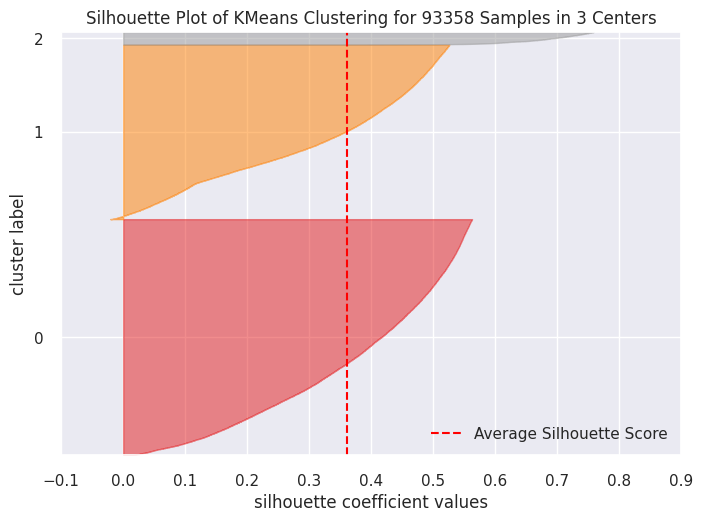

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_3var_3clus)

# Fit the data to the visualizer
visualizer.fit(rfm_3var_scaled)    
# Draw/show/poof the data
visualizer.poof()    

Avec 3 clusters, on remarque que les clusters ne sont pas homogènes, dont notamment un avec un score de silhouette très élévé.

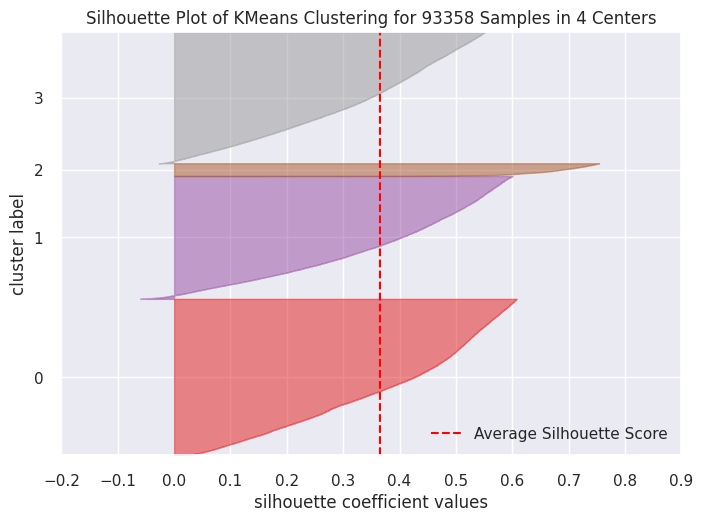

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_3var_4clus)

# Fit the data to the visualizer
visualizer.fit(rfm_3var_scaled)  
# Draw/show/poof the data
visualizer.poof()    

Avec 4 clusters, ceux-ci sont plus homogènes avec tout de même un petit cluster avec un score de silhouette très élévé.

On remarque tout de même que les scores de silhouettes sont légèrement meilleurs que sur la clusterisation avec 3 compartiments.

La répartition avec 4 clusters semble plus pertinente.

## Analyse métier des clusters

Ajoutons les labels à notre dataframe d'origine

In [29]:
# Initialize dataframe without scaled values
rfm_3var = df[rfm_features].copy()
# Add a column with the generated labels
rfm_3var["Clusters"] = kmeans_3var_4clus.labels_

Afin d'expliquer nos différents compartiments, affichons les statistiques de nos différents clusters.

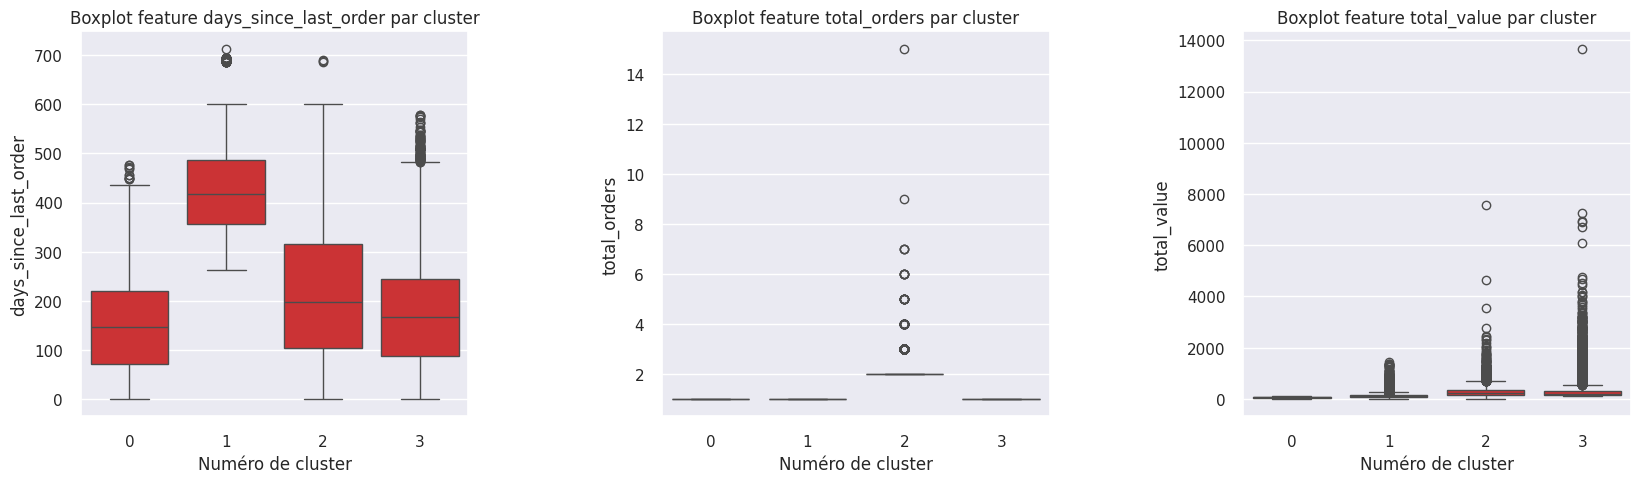

In [30]:
# Configure the grid for plots
plt.figure(figsize = (20, 5))
grid = plt.GridSpec(1, len(rfm_features), wspace=0.5, hspace=0.3)
for i in range(len(rfm_features)):
    # For each feature create a subplot
    plt.subplot(grid[0,i])
    # Plot a boxplot of the feature order by cluster
    sns.boxplot(x="Clusters", y=rfm_features[i], data=rfm_3var)
    plt.title(f"Boxplot feature {rfm_features[i]} par cluster")
    plt.xlabel("Numéro de cluster")
    plt.ylabel(f"{rfm_features[i]}")

Ainsi, nous pouvons catégoriser nos clients comme suit :
- **Premier cluster** : clients moins récents, faible fréquence et montant => **clients en déclin**
- **Deuxième cluster** : clients peu récents avec une faible fréquence et un faible montant => **clients perdus**
- **Troisième cluster** : clients très récents, actifs, avec un montant élevé => **champions**
- **Quatrième cluster** : nouveaux clients avec une faible fréquence mais un potentiel d'achat => **clients potentiels**

# K-Means avec 4 variables

On ajoute le score de commentaire moyen du client

In [31]:
# Define a list with the features needed for the RFM segmentation
rfm_features = ["days_since_last_order", "total_orders", "total_value", "mean_review_score"]
# Make a copy of the original dataframe, with only the required features
rfm_4var = df[rfm_features].copy()

On vérifie sa distribution

<Axes: xlabel='mean_review_score', ylabel='Density'>

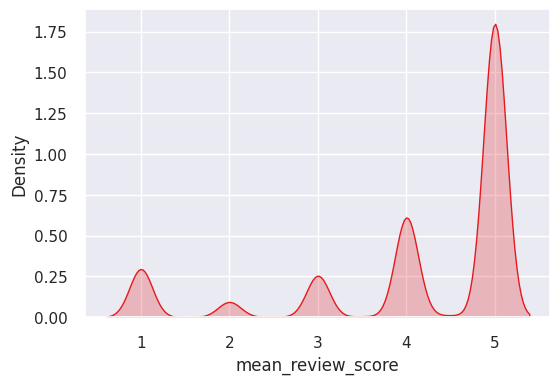

In [32]:
# Plot the distribution of the total_orders feature
plt.figure(figsize=(6,4))
sns.kdeplot(data=rfm_4var["mean_review_score"], fill=True)

La distribution est satisfaisante, nous procédons ensuite à la normalisation avec le même scaler que précédemment

In [33]:
# Define a StandardScaler object
scaler = StandardScaler()
# Use it on our dataframe to get standardized values
rfm_4var_scaled = scaler.fit_transform(rfm_4var)

## Choix du nombre de clusters

Afin de sélectionner le bon nombre de clusters, nous allons appliquer la méthode du coude d'une part et la méthode de la silhouette d'autre part

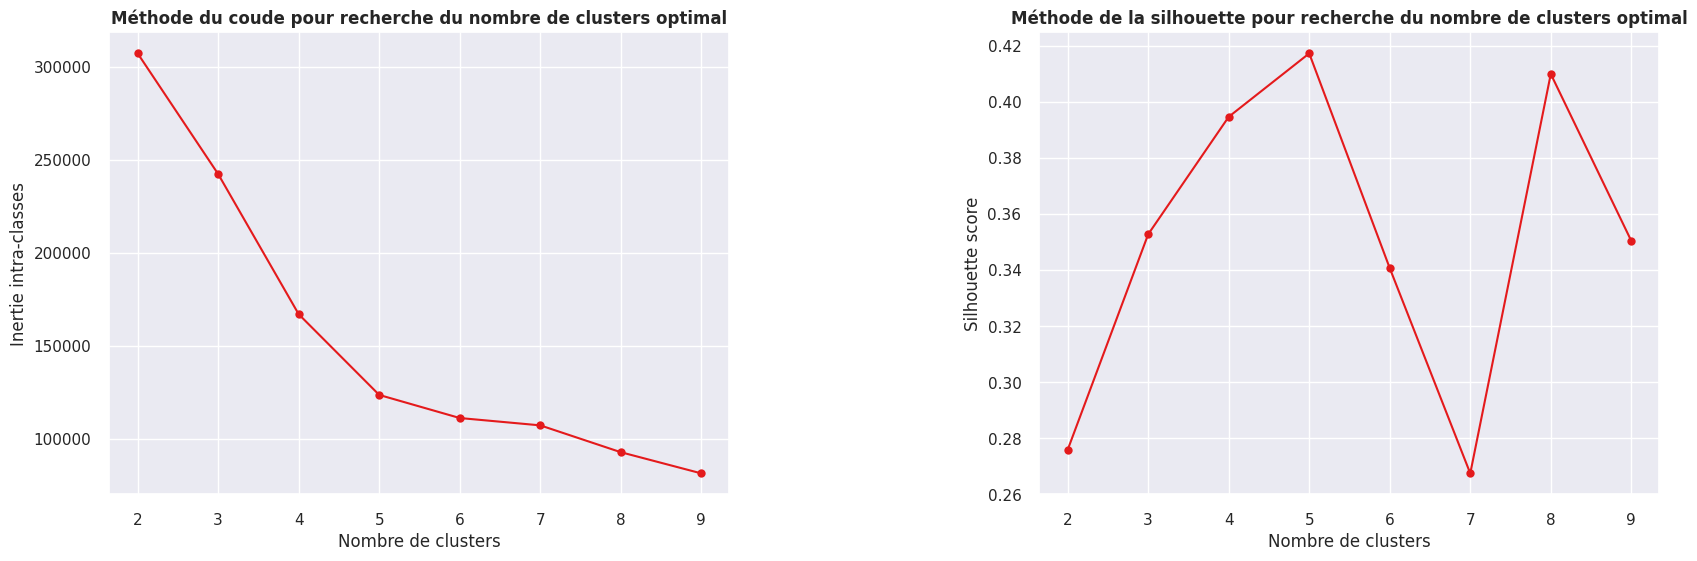

In [34]:
# Define a number of clusters, between 2 and 10
K = range(2,10)
# Define a list to store the inertias
inerties = []
# Define a list to store the silhouettes scores
silhouettes = []

for k in K:
    # Initialize the model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=8)
    # Train the model
    kmeans.fit(rfm_4var_scaled)
    # Get the computed labels
    cluster_labels = kmeans.labels_
    
    # Calcule inertia and silhouette scores
    inerties.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_4var_scaled, cluster_labels))

# Create a figure with 1 line and 2 columns
plt.figure(figsize = (20, 6))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)

# In the first subplot, plot the results of the elbow method
plt.subplot(grid[0,0])
plt.plot(K, inerties, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Inertie intra-classes") 
plt.title("Méthode du coude pour recherche du nombre de clusters optimal", fontweight="bold")

# In the second subplot, plot the results of the silhouette method
plt.subplot(grid[0,1])
plt.plot(K, silhouettes, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Silhouette score") 
plt.title("Méthode de la silhouette pour recherche du nombre de clusters optimal", fontweight="bold")

plt.show()

La méthode du coude préconise 5 clusters, cependant la méthode de la silhouette montre un score intéressant avec 8 clusters.

Nous essayerons les deux valeurs pour les départager.

## Clustering avec 5 et 8 clusters

Dans un premier temps visualisons les clusters produits sur un  graphique en deux dimensions avec :
- en X la récence
- en Y la moyenne de la fréquence et du montant

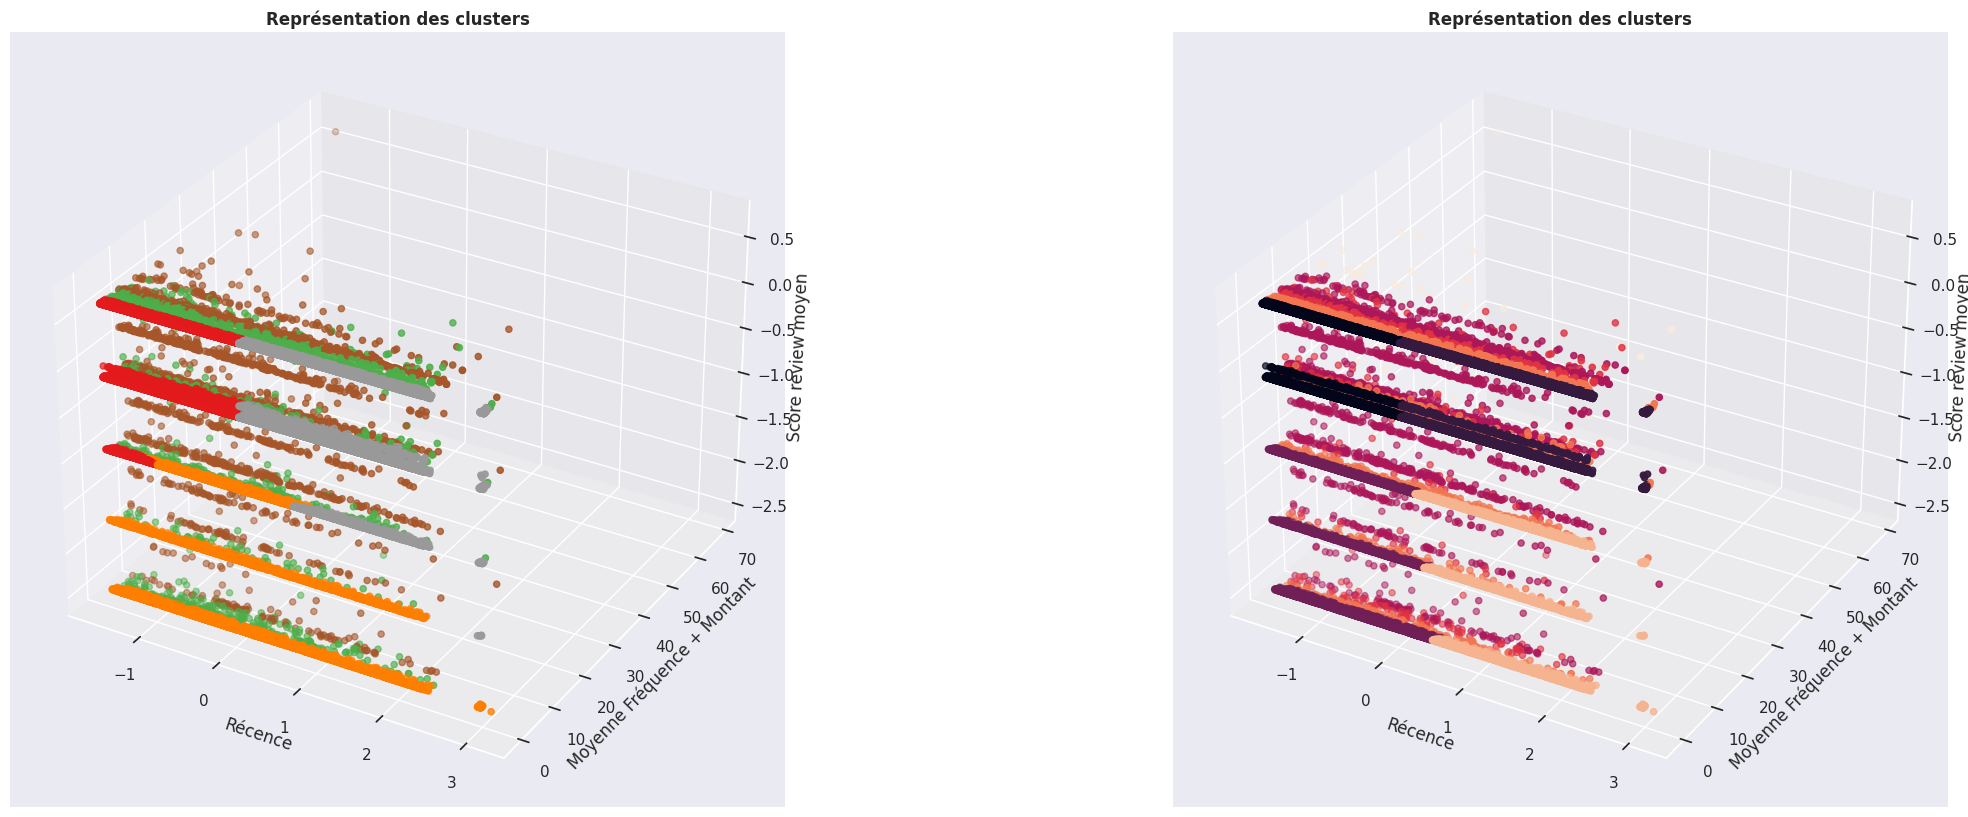

In [35]:
# Create a figure with 1 line and 2 columns
fig = plt.figure(figsize=(25,20))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)
sns.set_palette("Set1")

# Train the first model with 5 clusters
kmeans_4var_5clus = KMeans(n_clusters=5, random_state=8)
kmeans_4var_5clus.fit(rfm_4var_scaled)
# Define a 3D subplot
ax1 = fig.add_subplot(grid[0,0], projection="3d")
# Plot the values colored by labels
ax1.scatter(xs=rfm_4var_scaled[:, 0], ys=rfm_4var_scaled[:, 1]+rfm_4var_scaled[:, 2] / 2, 
    zs=rfm_4var_scaled[:, 3], c=kmeans_4var_5clus.labels_, cmap="Set1")
ax1.set_xlabel("Récence")
ax1.set_ylabel("Moyenne Fréquence + Montant")
ax1.set_zlabel("Score review moyen")
plt.title("Représentation des clusters", fontweight="bold")

# Train the first model with 8 clusters
kmeans_4var_8clus = KMeans(n_clusters=8, random_state=8)
kmeans_4var_8clus.fit(rfm_4var_scaled)
# Define a 3D subplot
ax2 = fig.add_subplot(grid[0,1], projection="3d")
# Plot the values colored by labels
ax2.scatter(rfm_4var_scaled[:, 0], rfm_4var_scaled[:, 1]+rfm_4var_scaled[:, 2] / 2, 
    rfm_4var_scaled[:, 3], c=kmeans_4var_8clus.labels_)
ax2.set_xlabel("Récence")
ax2.set_ylabel("Moyenne Fréquence + Montant")
ax2.set_zlabel("Score review moyen")
plt.title("Représentation des clusters", fontweight="bold")

plt.show()

Ensuite, nous visualisons les silhouettes des deux clusterings

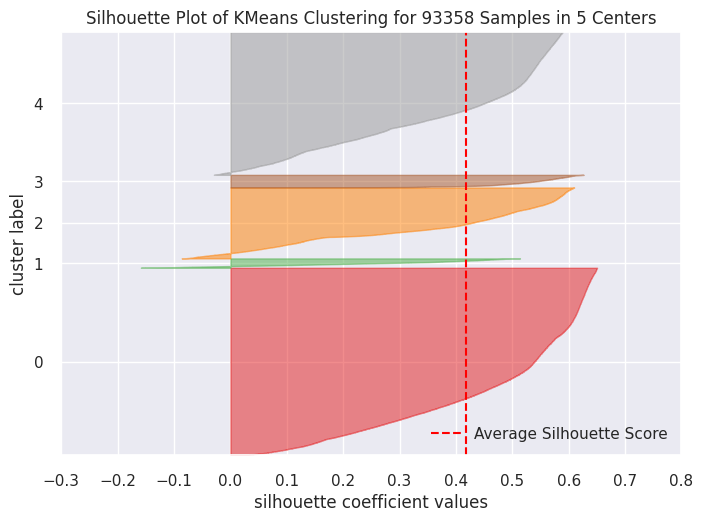

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [36]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_4var_5clus)

# Fit the data to the visualizer
visualizer.fit(rfm_4var_scaled)    
# Draw/show/poof the data
visualizer.poof()    

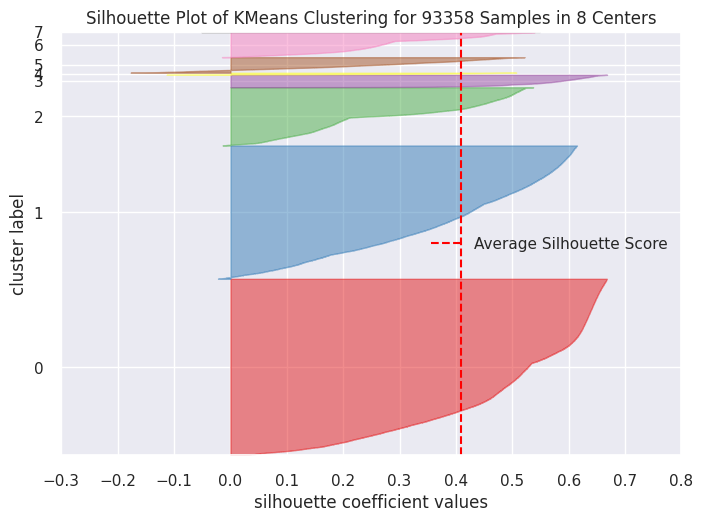

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [37]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_4var_8clus)

# Fit the data to the visualizer
visualizer.fit(rfm_4var_scaled)    
# Draw/show/poof the data
visualizer.poof()    

Les scores de silhouette et l'homogénéité sont meilleurs avec 5 clusters, nous poursuivrons l'analyse avec ce nombre de clusters

## Analyse métier des clusters

Ajoutons les labels à notre dataframe d'origine

In [38]:
# Initialize dataframe without scaled values
rfm_4var = df[rfm_features].copy()
# Add a column with the generated labels
rfm_4var["Clusters"] = kmeans_4var_5clus.labels_

Afin d'expliquer nos différents compartiments, affichons les statistiques de nos différents clusters.

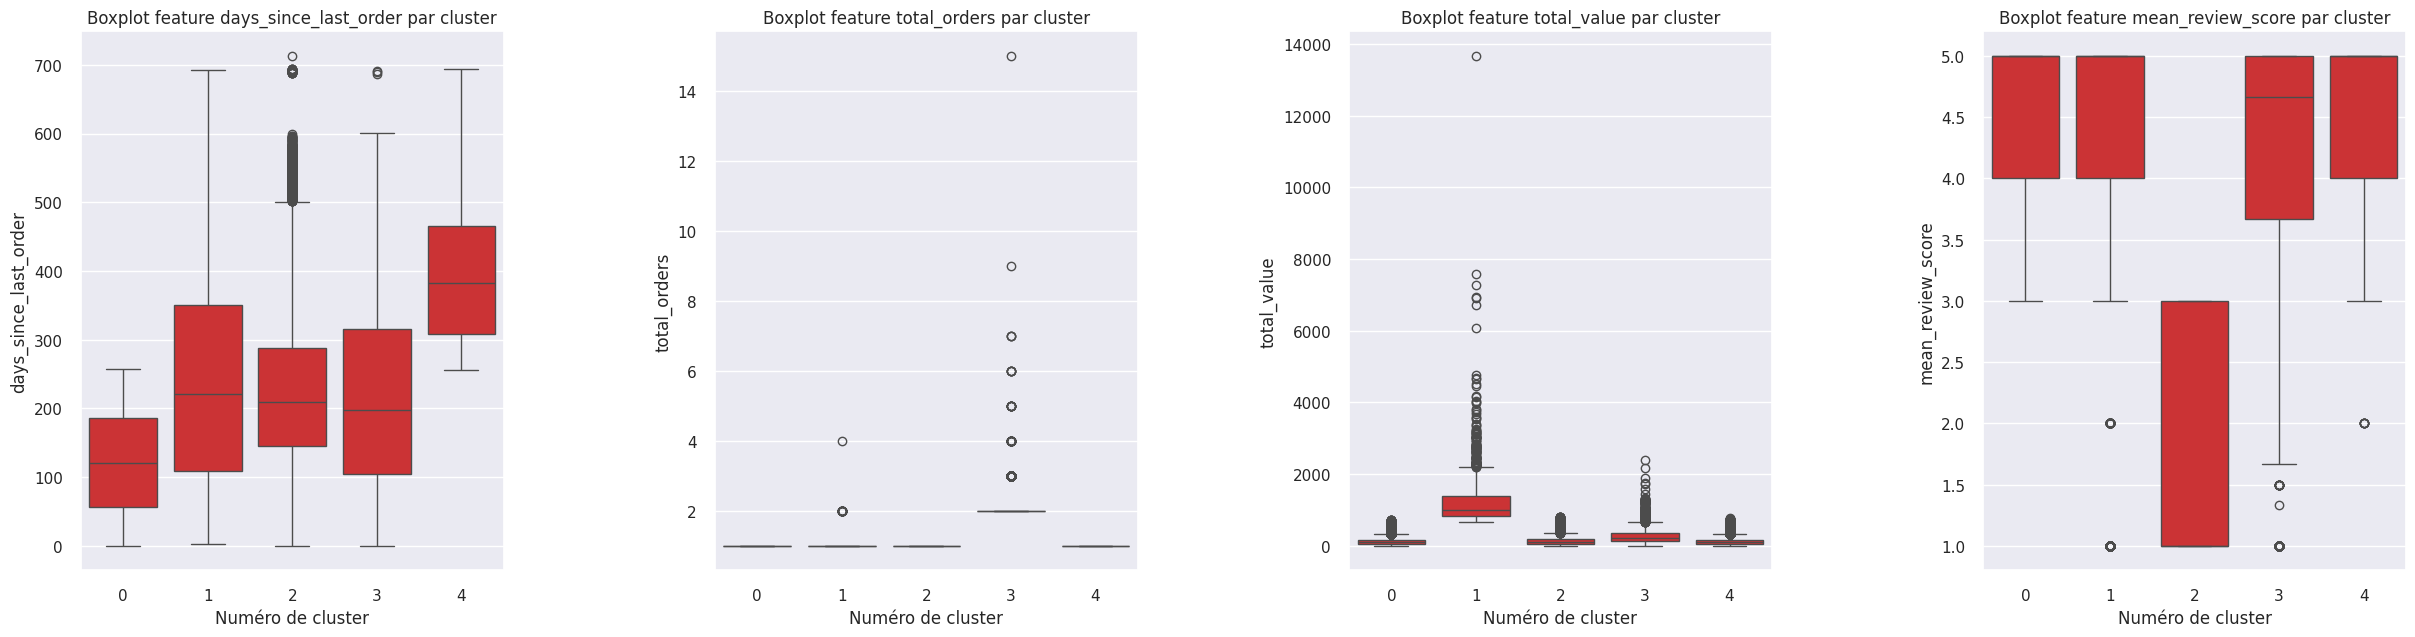

In [39]:
# Configure the grid for plots
plt.figure(figsize = (30, 7))
grid = plt.GridSpec(1, len(rfm_features), wspace=0.5, hspace=0.3)
for i in range(len(rfm_features)):
    # For each feature create a subplot
    plt.subplot(grid[0,i])
    # Plot a boxplot of the feature order by cluster
    sns.boxplot(x="Clusters", y=rfm_features[i], data=rfm_4var)
    plt.title(f"Boxplot feature {rfm_features[i]} par cluster")
    plt.xlabel("Numéro de cluster")
    plt.ylabel(f"{rfm_features[i]}")

Ainsi, nous pouvons catégoriser nos clients comme suit :
- **Premier cluster** : clients récents, faible fréquence et montant mais satisfaits => **clients potentiels**
- **Deuxième cluster** : clients moins récents, actifs, avec un montant élevé et satisfaits => **champions**
- **Troisième cluster** : clients moins récents, faible fréquence et montant mais non satisfaits => **clients perdus**
- **Quatrième cluster** : clients moins récents, actifs, avec un montant moyen et plutôt satisfaits => **clients fièles**
- **Cinquième cluster** : clients peu récents, faible fréquence et montant mais satisfaits => **clients en déclin**

# Dendogram

Nous allons à présent utiliser un dendrogramme afin de qualifier nos clients. Pour cela, et fort de nos constats précédents, nous utiliserons les 4 variables de la segmentation RFM.

L'algorithme nécessitant beaucoup de puissance de calculs, nous allons sélectionner un échantillon de nos données.

In [40]:
# Create a sample of our dataframe
rfm_sampled = pd.DataFrame(rfm_4var_scaled, columns=rfm_features).sample(n=10000, random_state=8)

Créons notre modèle

In [41]:
# Create a hierarchical clustering model
agglo_clust = AgglomerativeClustering(metric='euclidean', linkage='ward', 
                                      compute_full_tree=True, compute_distances=True)

Entrainons le modèle et visualisons 5 clusters, comme vu précédemment

In [42]:
# Fit the data to the model and determine which clusters each data point belongs to
agglo_clust.set_params(n_clusters=5)
clusters = agglo_clust.fit_predict(rfm_sampled) 
# Count of data points in each cluster
np.bincount(clusters) 

array([6315,  287,  492, 1816, 1090])

Ajoutons à présent le numéro de cluster à notre dataframe

In [43]:
# Create a dataframe with our scaled values
rfm_sampled_clustered = pd.DataFrame(rfm_sampled, columns=rfm_features)
# Add a column with the generated labels
rfm_sampled_clustered["Clusters"] = clusters

Affichons à présent notre dendrogram

In [44]:
def plot_dendrogram(model, **kwargs):
    """
    Create linkage matrix and then plot the dendrogram

    Parameters :
        - model : sklearn.clusters.AgglomerativeClustering
        - kwargs : parameters of the model
    """
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

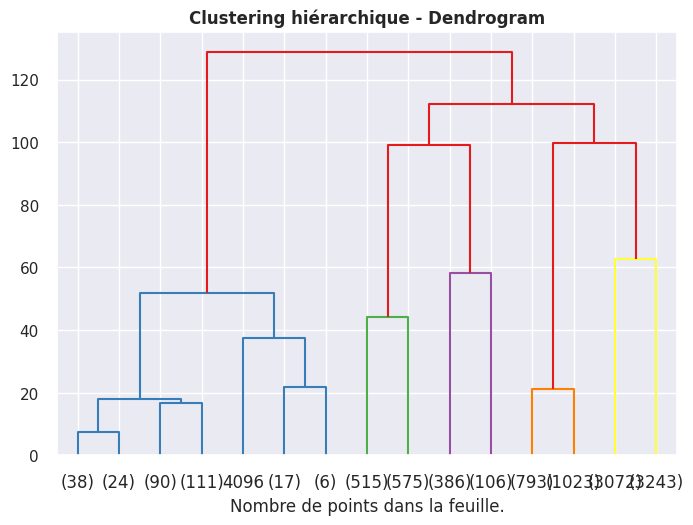

In [45]:
plt.title("Clustering hiérarchique - Dendrogram", fontweight="bold")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo_clust, truncate_mode="level", p=3)
plt.xlabel("Nombre de points dans la feuille.")
plt.show()

Calculons le score de silhouette de notre modèle

In [46]:
# Compute the silhouette score of the model
silhouette_score(rfm_sampled, clusters)

np.float64(0.3724500398870837)

Celui-ci montre moins de performance qu'avec le modèle k-means, analysons tout de même nos clusters d'un point de vue métier

Afin d'analyser nos clusters, affichons un boxplot de nos variables en fonction des clusters

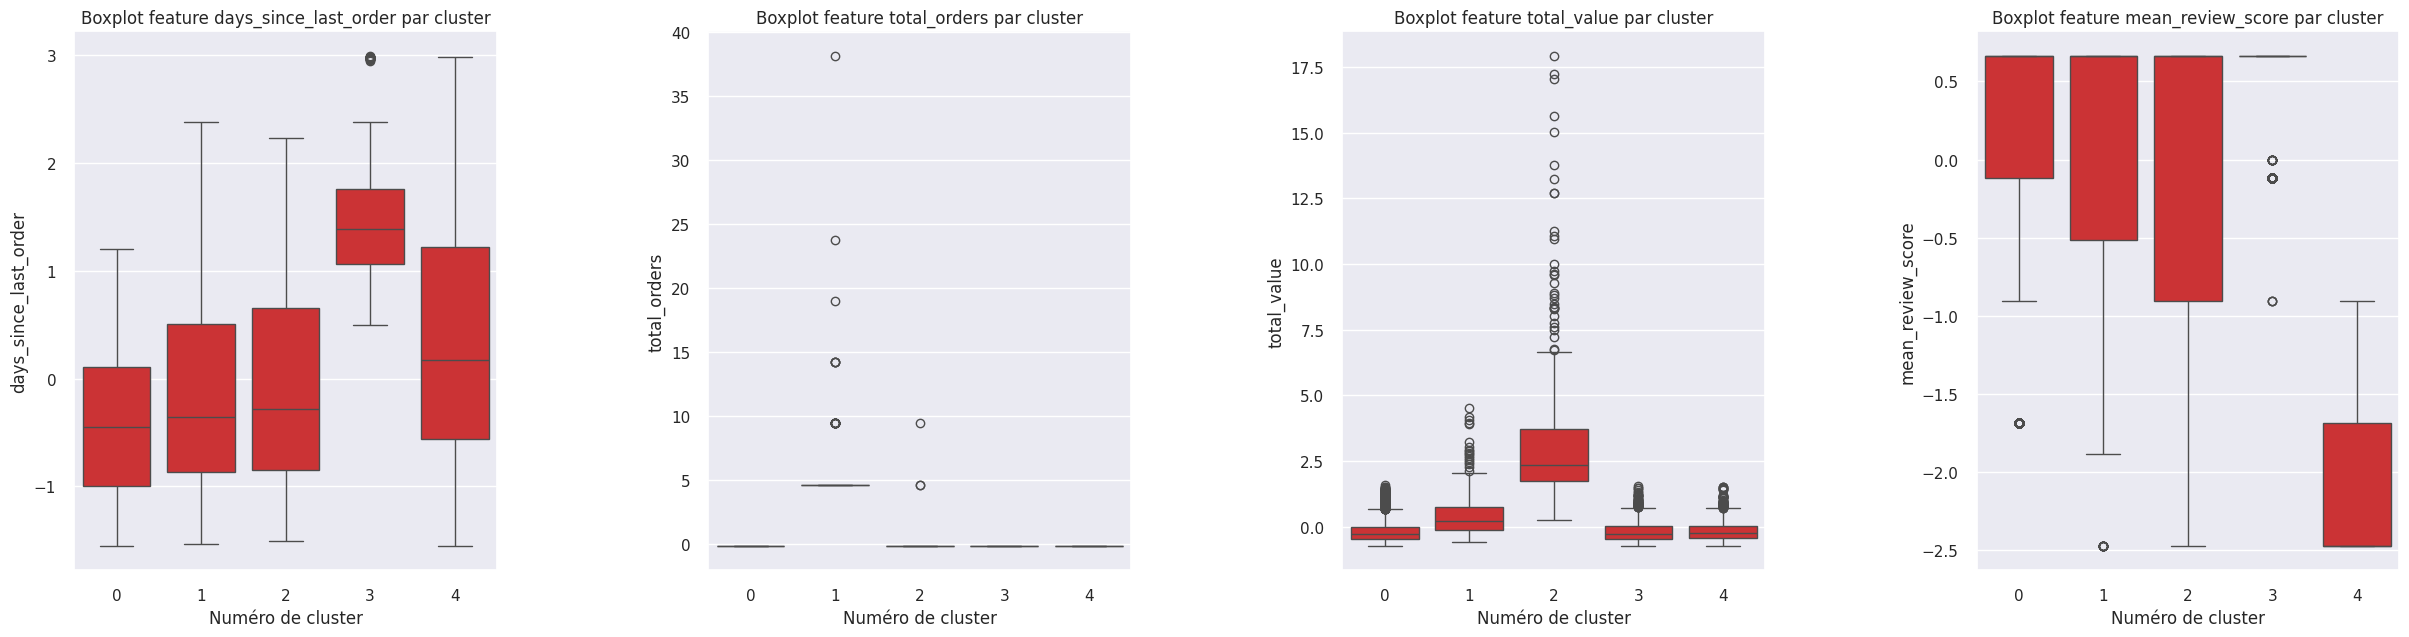

In [47]:
# Configure the grid for plots
plt.figure(figsize = (30, 7))
grid = plt.GridSpec(1, len(rfm_features), wspace=0.5, hspace=0.3)
for i in range(len(rfm_features)):
    # For each feature create a subplot
    plt.subplot(grid[0,i])
    # Plot a boxplot of the feature order by cluster
    sns.boxplot(x="Clusters", y=rfm_features[i], data=rfm_sampled_clustered)
    plt.title(f"Boxplot feature {rfm_features[i]} par cluster")
    plt.xlabel("Numéro de cluster")
    plt.ylabel(f"{rfm_features[i]}")

On constate en effet que les distinctions entre clusters sont plus difficiles à déterminer qu'avec l'algorithme k-means.

De plus, le clustering hiearchique est gourmand en ressources, ce pourquoi nous avons du créer un échantillon du dataframe, ce qui n'est pas forcément représentatif.

Pour la suite, nous retiendrons donc le k-means.

# DBScan

Nous allons à présent utiliser l'algorithme DBScan afin de qualifier nos clients. Pour cela, et fort de nos constats précédents, nous utiliserons les 4 variables de la segmentation RFM.

L'algorithme nécessitant beaucoup de puissance de calculs, nous allons sélectionner un échantillon de nos données.

In [48]:
# Create a sample of our dataframe
rfm_sampled = pd.DataFrame(rfm_4var_scaled, columns=rfm_features).sample(n=10000, random_state=8)

Cherchons à déterminer l'epsilon optimal pour obtenir un meilleur partitionnement

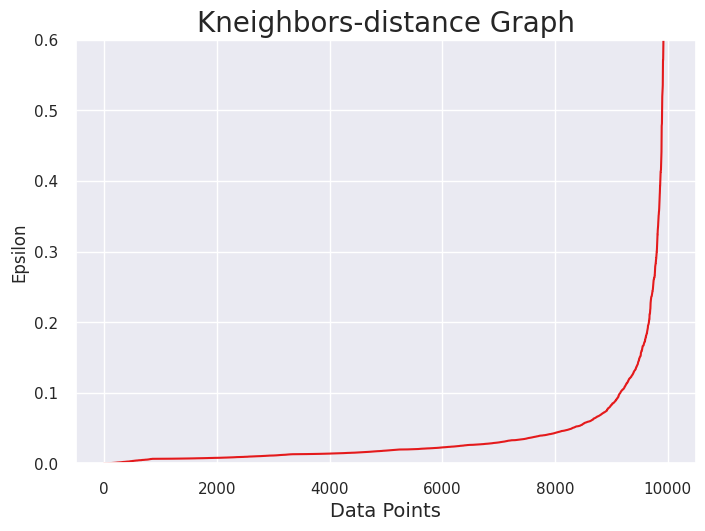

In [49]:
# Initialize a NearestNeighbors algorithm and train it with our data
neighbors = NearestNeighbors(n_neighbors=8)
nbrs = neighbors.fit(rfm_sampled)
# Compute the distances and indices of our data
distances, indices = nbrs.kneighbors(rfm_sampled)
# Sort distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]
# Plot the distances regarding the number of points
plt.plot(distances)
plt.ylim([0, 0.6])
plt.title('Kneighbors-distance Graph',fontsize=20)
plt.xlabel('Data Points',fontsize=14)
plt.ylabel('Epsilon')
plt.show()

Nous allons choisir un epsilon tel que 95% environ des observations aient une distance au proche voisin inférieure à epsilon, soit environ 0.35 ici.

In [50]:
# Initialize a DBSCAN algorithm
dbscan = DBSCAN(eps=0.35, min_samples=8, n_jobs=-1)
# Train it and predict the labels for our data
clusters = dbscan.fit_predict(rfm_sampled)

Ajoutons à présent le numéro de cluster à notre dataframe

In [51]:
rfm_sampled_clustered = pd.DataFrame(rfm_sampled, columns=rfm_features)
# Add the labels to the dataframe
rfm_sampled_clustered["Clusters"] = clusters

Calculons le score de silhouette de notre modèle

In [53]:
# Compute the silhouette score of the model
silhouette_score(rfm_sampled, clusters)

np.float64(0.12327498974716795)

Afin d'analyser nos clusters, affichons un boxplot de nos variables en fonction des clusters

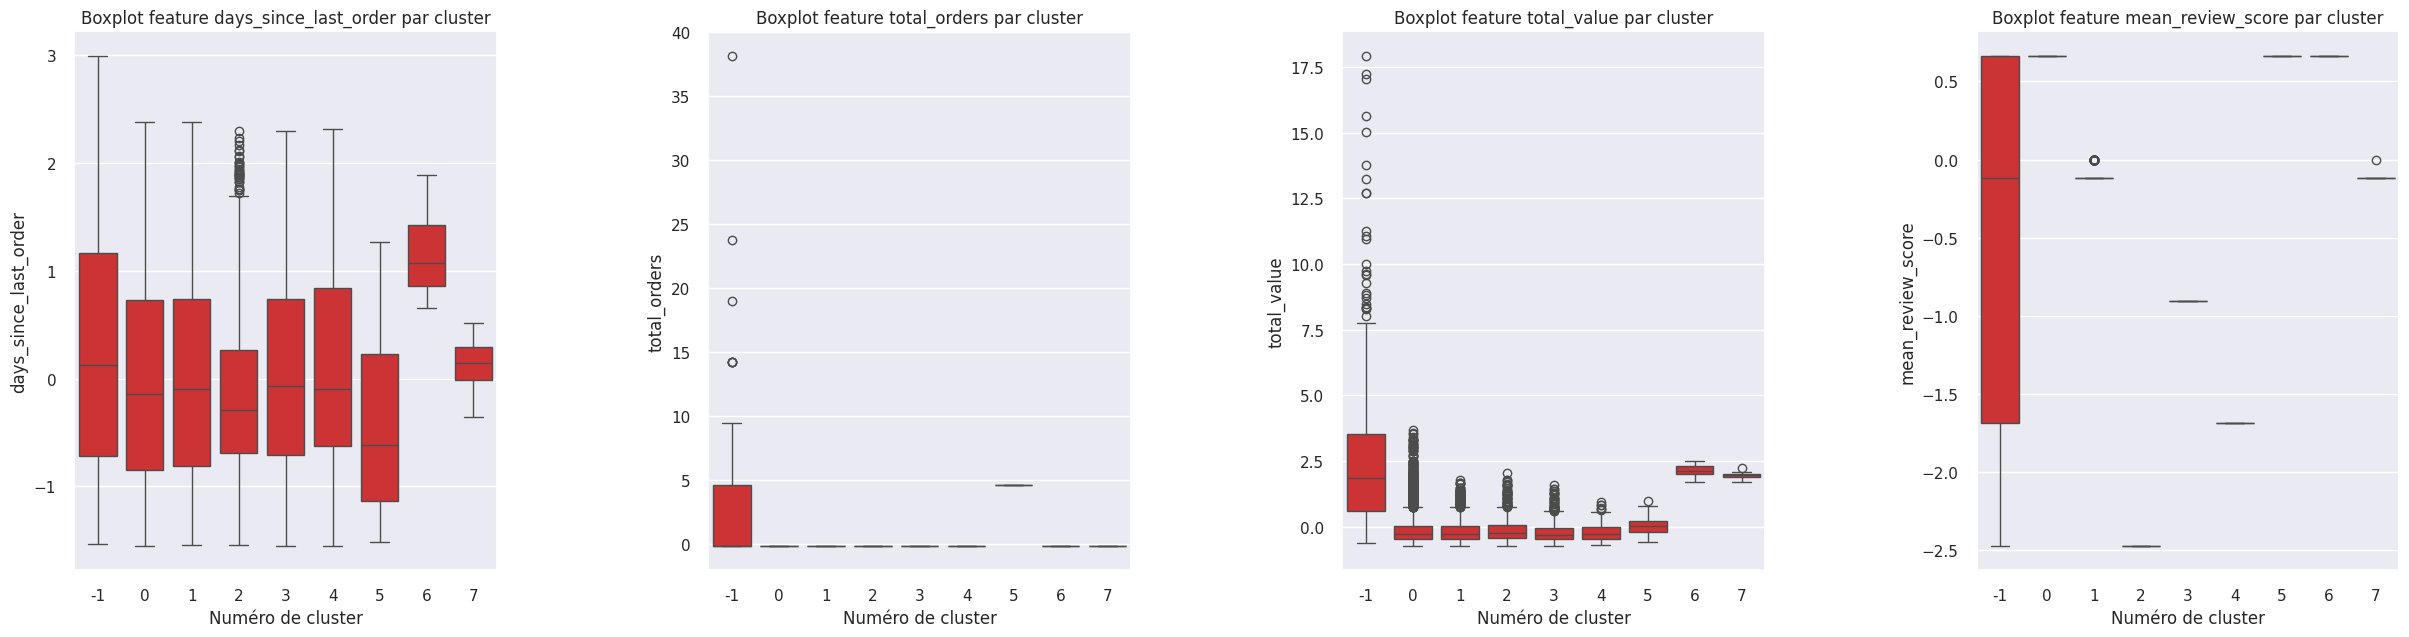

In [54]:
# Configure the grid for plots
plt.figure(figsize = (30, 7))
grid = plt.GridSpec(1, len(rfm_features), wspace=0.5, hspace=0.3)
for i in range(len(rfm_features)):
    # For each feature create a subplot
    plt.subplot(grid[0,i])
    # Plot a boxplot of the feature order by cluster
    sns.boxplot(x="Clusters", y=rfm_features[i], data=rfm_sampled_clustered)
    plt.title(f"Boxplot feature {rfm_features[i]} par cluster")
    plt.xlabel("Numéro de cluster")
    plt.ylabel(f"{rfm_features[i]}")

Le score est très mauvais en comparaison de l'algorithme k-means et les clusters très compliqués à distinguer. Nous ne retiendrons pas le DBScan pour nos travaux.

# Evaluons la stabilité de nos clusters

Nous allons évaluer la stabilité de notre clustering avec KMeans et 4 variables.

Pour cela, nous allons fixer le nombre de fois que l'algorithme sera exécuté avec différents centroides à 1 (n_init) et supprimer le random_state. Nous comparerons ensuite les différents scores d'interties.

In [55]:
# Create a list to store inertias
inertias = []
for i in range(1,21):
    # Initialize i models with the same number of clusters 
    kmeans = KMeans(n_clusters=5, n_init=1)
    # Train the model and make predictions
    kmeans.fit_predict(rfm_4var_scaled)
    # Store the inertias in the list
    inertias.append(kmeans.inertia_)

Text(0, 0.5, 'Inertie')

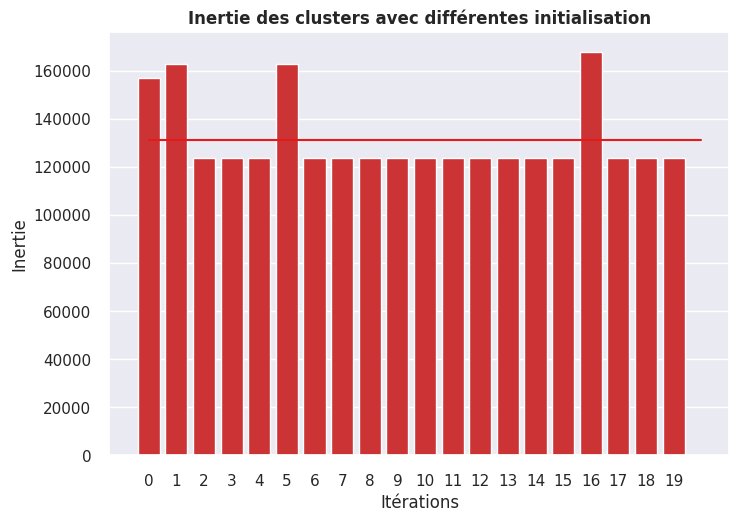

In [56]:
# Plot a barplot of computed inertias
sns.barplot(inertias)
# Add a line with the mean of inertias
sns.lineplot(x=[0,20], y=sum(inertias)/len(inertias))
plt.title("Inertie des clusters avec différentes initialisation", fontweight="bold")
plt.xlabel("Itérations")
plt.ylabel("Inertie")

On remarque que nos clusters sont plutôt stables à l'initialisation